In [ ]:
!pip install -U segmentation-models

In [ ]:
!pip install gradio

In [8]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
from PIL import Image 
import numpy as np 
import segmentation_models as sm
from matplotlib import pyplot as plt
import random

Segmentation Models: using `tf.keras` framework.


In [9]:
from keras import backend as K
from keras.models import load_model

In [10]:
import gradio as gr

In [11]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [12]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [13]:
# get the satellite_segmentation_full.h5 from drive 
!gdown --id 1sf7s99IvoLW6xV7f8nymJqyambf79RYB

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sf7s99IvoLW6xV7f8nymJqyambf79RYB
To: /content/satellite_segmentation_full.h5
100% 23.5M/23.5M [00:00<00:00, 98.9MB/s]


In [14]:
satellite_model = load_model('/content/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 
                                          'jaccard_coef': jaccard_coef}))

In [ ]:
#satellite_model.get_config()

In [61]:
# get test iamge from drive
!gdown --id 1ScS3aYOXojOZf-FDiZ1SD5Wk43oTCXjP

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ScS3aYOXojOZf-FDiZ1SD5Wk43oTCXjP
To: /content/test_region.png
100% 2.31M/2.31M [00:00<00:00, 135MB/s]


In [62]:
from PIL import Image
import numpy as np

# Load the image and resize it to 256x256
image = Image.open('test_region.png')
image = image.resize((256, 256))

# Convert the image to a numpy array and remove the alpha channel
image = np.array(image)
image = image[:, :, :3]

# Add a batch dimension to the array
image = np.expand_dims(image, 0)
print(image.shape)

(1, 256, 256, 3)


In [63]:
prediction = satellite_model.predict(image)

1/1 [==============================] - 0s 186ms/step


In [64]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

In [65]:
type(predicted_image)

numpy.ndarray

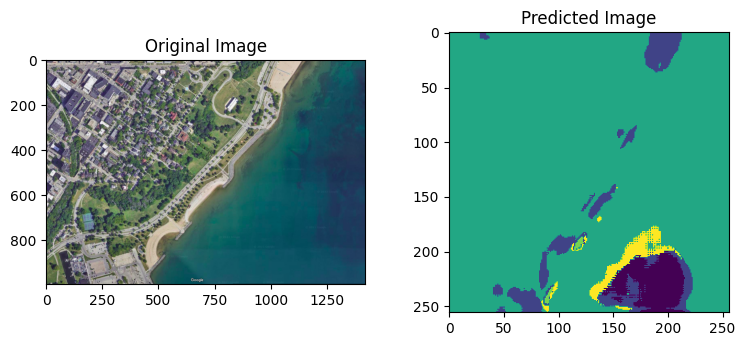

In [66]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('test_region.png'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)

In [82]:
from PIL import Image
import numpy as np

def process_input_image(image_source):
    # Convert the numpy array to a PIL Image object
    image = Image.fromarray(np.uint8(image_source))
    
    # Resize the image
    image = image.resize((256, 256))
    
    # Convert the image back to a numpy array
    image = np.array(image)
    
    # Expand the dimensions of the image to match the expected input shape of the model
    image = np.expand_dims(image, axis=0)
    
    # Predict the mask for the image
    prediction = satellite_model.predict(image)
    predicted_image = np.argmax(prediction, axis=3)

    predicted_image = predicted_image[0,:,:]
    predicted_image = predicted_image * 50
    
    return 'Predicted Masked Image', predicted_image


In [83]:
my_app = gr.Blocks()

In [84]:
with my_app:
  gr.Markdown("Statellite Image Segmentation Application UI with Gradio")
  with gr.Tabs():
    with gr.TabItem("Select your image"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image", shape=(256, 256))
            source_image_loader = gr.Button("Load above Image")
        with gr.Column():
            output_label = gr.Label(label="Image Info")
            img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [
            img_source
        ],
        [
            output_label,
            img_output
        ]
    )

In [85]:
my_app.launch(debug=True,share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://b920e95314759a0477.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 328ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b920e95314759a0477.gradio.live


In [86]:
my_app.close()

Closing server running on port: 7860
